# Training model

## Import

In [1]:
#import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import random
import io
import imageio
from google.colab import drive
drive.mount('//content//drive')

from tensorflow import keras
from keras.initializers import RandomNormal
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, LeakyReLU, Dropout, Reshape, Conv2DTranspose, BatchNormalization
from keras.optimizers import Adam

Mounted at //content//drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


11490434/11490434 [==============================] - 0s 0us/step


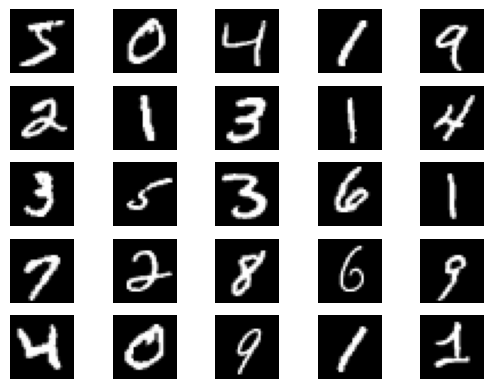

In [3]:
#load mnist
(x_train, y_train), (_, _) = mnist.load_data()
x_train = np.expand_dims(x_train / 255, axis=-1).astype('float32')

n_samples = 25
#look at the samples of mnist
for i in range(n_samples):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(x_train[i], cmap='gray')
plt.show()

In [4]:
datasets = []

for i in range(10):
    var_dataset = x_train[[x == i for x in y_train]]
    datasets.append(var_dataset)

max_length = min([len(x) for x in datasets])

for i in range(len(datasets)):
    datasets[i] = datasets[i][:max_length]

## Models

In [14]:
#define discriminator model
def define_discriminator():
    discriminator = Sequential([
    Conv2D(32, (4, 4), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), input_shape=(28,28,1)),
    BatchNormalization(trainable=True),
    LeakyReLU(alpha=0.3),
    Dropout(0.8),

    Conv2D(32, (4, 4), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
    BatchNormalization(trainable=True),
    LeakyReLU(alpha=0.3),
    Dropout(0.8),

    Flatten(),
    Dense(1, activation='sigmoid')
    ])

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    return discriminator

#build discriminztor
d_models = [define_discriminator() for i in range(10)]

#look at architecture of discriminator
d_models[0].summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 14, 14, 32)        544       
                                                                 
 batch_normalization_40 (Bat  (None, 14, 14, 32)       128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_50 (LeakyReLU)  (None, 14, 14, 32)        0         
                                                                 
 dropout_20 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_51 (Conv2D)          (None, 7, 7, 32)          16416     
                                                                 
 batch_normalization_41 (Bat  (None, 7, 7, 32)         128       
 chNormalization)                                    

In [15]:
#define generator model
def define_generator(latent_dim):
    generator = Sequential([
    Dense(64 * 7 * 7, input_dim=latent_dim),
    LeakyReLU(alpha=0.2),
    Reshape((7, 7, 64)),

    Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
    BatchNormalization(trainable=True),
    Conv2D(64, (3, 3), padding='same'),
    LeakyReLU(alpha=0.2),

    Conv2DTranspose(32, (4,4), strides=(2,2), padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
    BatchNormalization(trainable=True),
    Conv2D(32, (3, 3), padding='same'),
    LeakyReLU(alpha=0.2),

    Conv2D(1, (7,7), activation='sigmoid', padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))
    ])

    return generator

#set the constant
latent_dim = 100
#build generator
g_models = [define_generator(latent_dim) for i in range(10)]
#look at architecture of generator
g_models[0].summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 3136)              316736    
                                                                 
 leaky_re_lu_70 (LeakyReLU)  (None, 3136)              0         
                                                                 
 reshape_10 (Reshape)        (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_20 (Conv2D  (None, 14, 14, 64)       65600     
 Transpose)                                                      
                                                                 
 batch_normalization_60 (Bat  (None, 14, 14, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_70 (Conv2D)          (None, 14, 14, 64)      

In [16]:
#define GAN model
def define_gan(g_model, d_model):
    d_model.trainable = False

    gan = Sequential()
    gan.add(g_model)
    gan.add(d_model)

    gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return gan

#create GAN
gan_models = [define_gan(g_models[i], d_models[i]) for i in range(10)]
#look at GAN architecture
gan_models[0].summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_40 (Sequential)  (None, 28, 28, 1)         463265    
                                                                 
 sequential_30 (Sequential)  (None, 1)                 18785     
                                                                 
Total params: 482,050
Trainable params: 463,073
Non-trainable params: 18,977
_________________________________________________________________


## Helping Functions

In [13]:
#function which load and preprocess train samples
def load_real_samples():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = np.expand_dims(x_train / 255, axis=-1).astype('float32')
    return x_train

#function which select random samples from train samples
def select_real_samples(dataset, quantity):
    selected_indexes = [random.randint(0, len(dataset) - 1) for _ in range(quantity)]
    selected_samples = dataset[selected_indexes]
    label_real = np.ones((quantity, 1))
    return selected_samples, label_real

#function which generate points in latent space
def generate_latent_points(latent_dim, n_samples):
    points = np.random.randn(latent_dim * n_samples)
    points = points.reshape(n_samples, latent_dim)
    return points

#function which generate fake samples
def generate_fake_samples(g_model, latent_dim, n_samples):
    points = generate_latent_points(latent_dim, n_samples)
    samples = g_model.predict(points)
    real_labels = np.zeros((n_samples, 1))
    return samples, real_labels

#function to display generated images
def show_images(examples, n):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()

#fuction to save 'subplot' images
def save_images(examples, n):
    a = io.BytesIO()
    plt.figure()
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.savefig(a, format='png')
    plt.close()
    a.seek(0)
    image = plt.imread(a)
    combined_image = np.asarray(image)
    return combined_image

## Training functions

In [19]:
loss_disc_per_batch = []
loss_gan_per_batch = []
#function to train GAN
def train(g_models, d_models, gan_models, datasets, latent_dim, base_path, epochs, batch_size):
    global loss_disc_per_batch, loss_gan_per_batch
    for q in range(len(datasets)):
        dataset = datasets[q]
        number_batches = int(dataset.shape[0] / batch_size)
        latent_points = generate_latent_points(100, 25)
        var_predictions = []
        #training by epochs
        for i in range(epochs):
            #trainig by batches in epoch
            for j in range(number_batches):
                #traning
                X_real, y_real = select_real_samples(dataset, batch_size // 2)
                X_fake, y_fake = generate_fake_samples(g_models[q], latent_dim, batch_size //2)
                X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
                d_loss, _ = d_models[q].train_on_batch(X, y)
                X_gan = generate_latent_points(latent_dim, batch_size)
                y_gan = np.ones((batch_size, 1))
                gan_loss = gan_models[q].train_on_batch(X_gan, y_gan)
                #print
                print(f'>number {q}, epoch {i+1}, batch {j+1}/{number_batches}, \n         disc loss={d_loss}, \n         gan loss={gan_loss}')
                #loss
                loss_disc_per_batch.append(d_loss)
                loss_gan_per_batch.append(gan_loss)
            #save epoch result
            X = g_models[q].predict(latent_points)
            predicted_image = save_images(X, 5)
            var_predictions.append(predicted_image)
            #show result
            if i % 10 == 0:
                show_images(X, 5)
        # save gif
        output_file = base_path + f'GAN_1.4_requesting_gif_{q}.gif'
        imageio.mimsave(output_file, var_predictions)
        # saving model weights
        g_weights_path = base_path + f'requesting_GAN_g_{q}_model.h5'
        g_models[q].save_weights(g_weights_path)

## Train models

In [ ]:
#train GAN
train(g_models, d_models, gan_models, datasets, latent_dim, base_path = 'drive//MyDrive//weights//', epochs=100, batch_size=256)

## Look at results \ Saving weights \ Loading weights

1/1 [==============================] - 0s 76ms/step


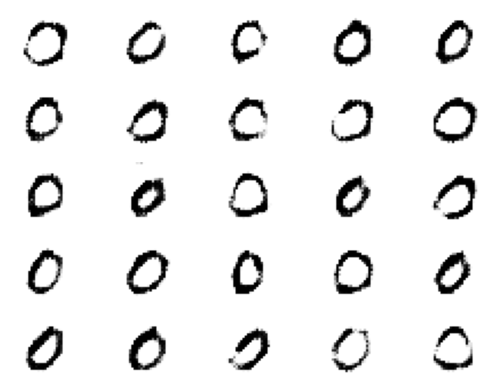

1/1 [==============================] - 0s 196ms/step


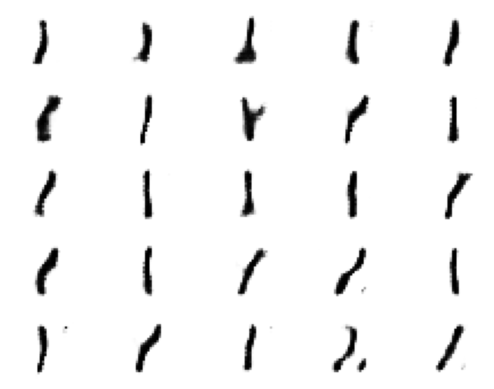

1/1 [==============================] - 0s 73ms/step


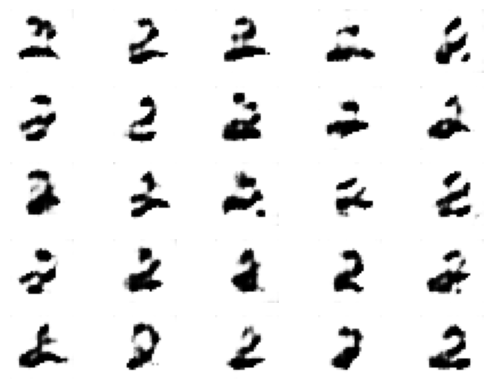

1/1 [==============================] - 0s 184ms/step


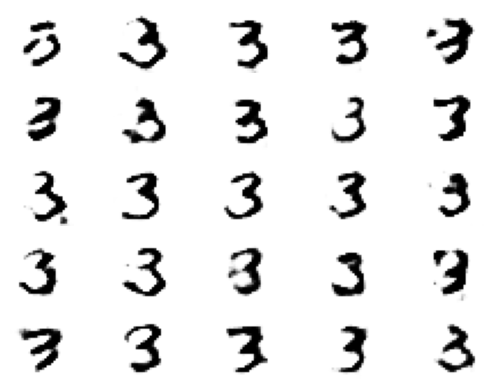

1/1 [==============================] - 0s 68ms/step


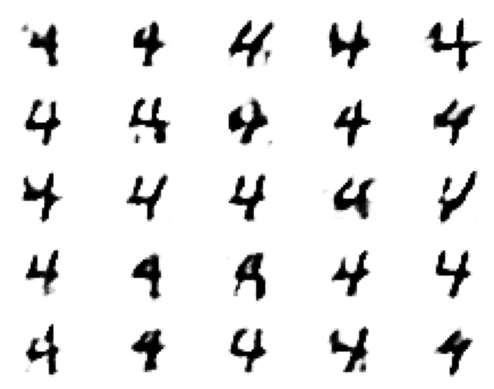

1/1 [==============================] - 0s 289ms/step


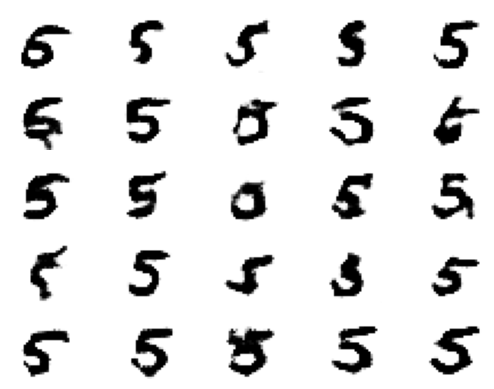

1/1 [==============================] - 0s 74ms/step


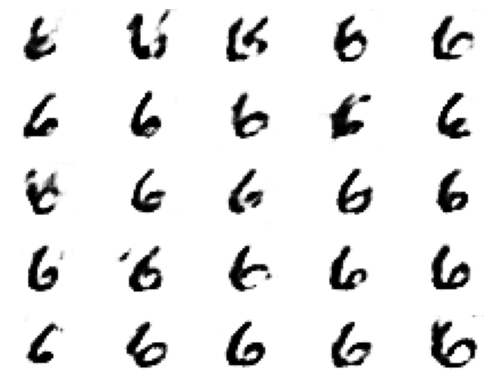

1/1 [==============================] - 0s 187ms/step


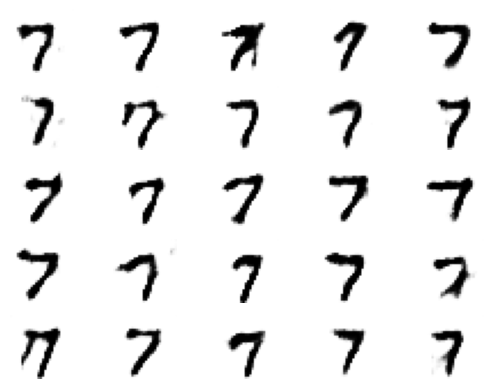

1/1 [==============================] - 0s 67ms/step


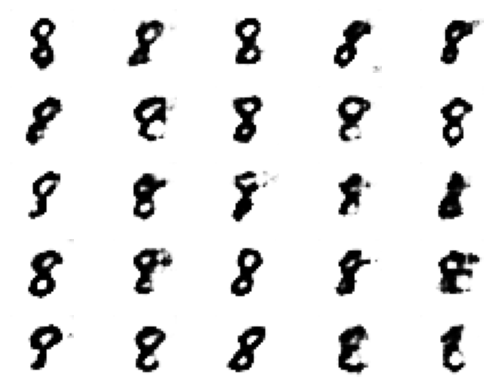

1/1 [==============================] - 0s 181ms/step


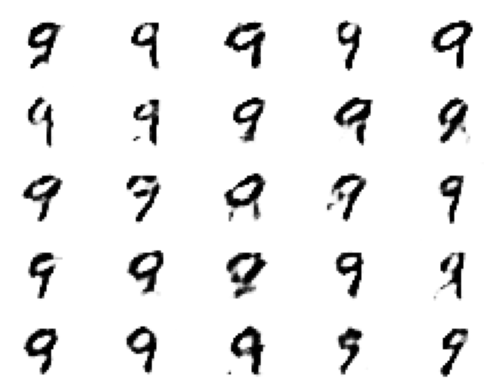

In [14]:
for i in range(10):
    latent_points = generate_latent_points(100, 25)
    X = g_models[i].predict(latent_points)
    show_images(X, 5)

# Using Model

## Input

In [5]:
print('please write a prompt separating the words with a space')
#prompt = input()
prompt = '2468'

please write a prompt separating the words with a space


## Prepare prompt

In [6]:
possible_prompts = {
    '[1,0,0,0,0,0,0,0,0,0]': ['0', 'zero'],
    '[0,1,0,0,0,0,0,0,0,0]': ['1', 'one'],
    '[0,0,1,0,0,0,0,0,0,0]': ['2', 'two'],
    '[0,0,0,1,0,0,0,0,0,0]': ['3', 'three'],
    '[0,0,0,0,1,0,0,0,0,0]': ['4', 'four'],
    '[0,0,0,0,0,1,0,0,0,0]': ['5', 'five'],
    '[0,0,0,0,0,0,1,0,0,0]': ['6', 'six'],
    '[0,0,0,0,0,0,0,1,0,0]': ['7', 'seven'],
    '[0,0,0,0,0,0,0,0,1,0]': ['8', 'eight'],
    '[0,0,0,0,0,0,0,0,0,1]': ['9', 'nine']}
if prompt.count(' ') != 0:
    prompt = prompt.split(' ')

nn_prompt = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
for i in prompt:
    for key, values in possible_prompts.items():
        if i in values:
            nn_prompt += np.array(eval(key))
print(nn_prompt)

[0 0 1 0 1 0 1 0 1 0]


## Fast model creation, defining help functions

In [7]:
#define generator model
def define_generator(latent_dim):
    generator = Sequential([
    Dense(64 * 7 * 7, input_dim=latent_dim),
    LeakyReLU(alpha=0.2),
    Reshape((7, 7, 64)),

    Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
    BatchNormalization(trainable=True),
    Conv2D(64, (3, 3), padding='same'),
    LeakyReLU(alpha=0.2),

    Conv2DTranspose(32, (4,4), strides=(2,2), padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
    BatchNormalization(trainable=True),
    Conv2D(32, (3, 3), padding='same'),
    LeakyReLU(alpha=0.2),

    Conv2D(1, (7,7), activation='sigmoid', padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))
    ])

    return generator

#set the constant
latent_dim = 100
#build generator
g_models = [define_generator(latent_dim) for i in range(10)]

In [8]:
#function which generate points in latent space
def generate_latent_points(latent_dim, n_samples):
    points = np.random.randn(latent_dim * n_samples)
    points = points.reshape(n_samples, latent_dim)
    return points

## Loading weights

In [9]:
base_path = 'drive//MyDrive//weights//'
for i in range(10):
    g_weights = base_path + f'requesting_GAN_g_{i}_model.h5'
    g_models[i].load_weights(g_weights)

## Models preparation

In [10]:
curent_models = list(np.array(g_models)[[i == 1 for i in nn_prompt]])

## Generate samples

1/1 [==============================] - 0s 24ms/step


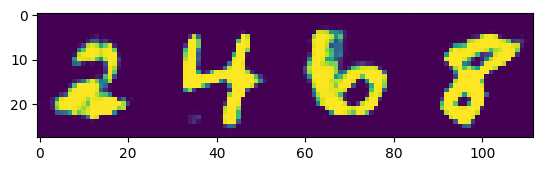

In [23]:
latent_points = generate_latent_points(100, 1)
samples = np.array([curent_models[0].predict(generate_latent_points(100, 1))]).reshape(28, 28, 1)
for i in range(1, len(curent_models)):
    prediction = curent_models[i].predict(generate_latent_points(100, 1))[0]
    samples = np.concatenate((samples, prediction), axis=1)
samples
plt.imshow(samples)